# TP: Let’s reverse-engineer the data center
Juan Rios

# Least squares

In [42]:
import numpy as np
import matplotlib.pyplot as plt

In [43]:
# Loading data
data_matrix_train, COP_train, data_matrix_test, COP_test, names = np.load('data_center_data_matrix.npy', allow_pickle=True)


## 3.1

Show that if $Aw = b$ then $y(t) = \frac{\omega_{1}^{T}\widetilde{x}(t) + \omega_{0}}{\omega_{2}^{T}\widetilde{x}(t) + 1}$.

We know that $Aw = {\widetilde{x}(t)^{T}\omega_{1} + \omega_{0} - y(t) \times \widetilde{x}(t)^{T}}$  

And $b = y(t)$

So if $Aw = b$ then $y(t) = {\widetilde{x}(t)^{T}\omega_{1} + \omega_{0} - y(t) \times \widetilde{x}(t)^{T}}$

That is $y(t) = \frac{\omega_{1}^{T}\widetilde{x}(t) + \omega_{0}}{\omega_{2}^{T}\widetilde{x}(t) + 1}$

## 3.2

In [44]:
# Constructing matrices for min_w ||A w - b||_2**2
matrix_mean = np.mean(data_matrix_train, axis=0)
M = data_matrix_train - matrix_mean
matrix_std = np.std(M, axis=0)
M = M / matrix_std

A = np.hstack([M, np.ones((M.shape[0],1)), -(M.T * COP_train[:,3]).T])
b = COP_train[:,3]


In [45]:
lstsq = np.linalg.lstsq(A, b, rcond=None)

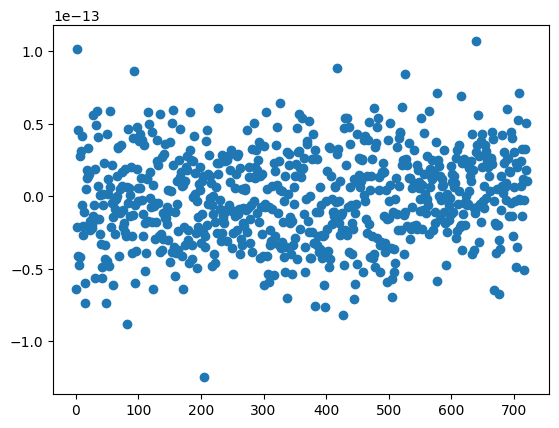

In [46]:
# Plot scatter of y = A w - b 
plt.scatter(np.arange(len(b)), A @ lstsq[0] - b)
plt.show()

In [47]:
# Constructing matrices for the test set

M_test = (data_matrix_test - matrix_mean) / matrix_std
A_test = np.hstack([M_test, np.ones((M_test.shape[0],1)), -(M_test.T * COP_test[:,3]).T])
b_test = COP_test[:,3]

## 3.3

In [48]:
#Evaluate the model on the test set
print("The mean squared error on the test set is: ", np.mean((A_test @ lstsq[0] - b_test)**2))
print("The mean absolute error on the test set is: ", np.mean(np.abs(A_test @ lstsq[0] - b_test)))


The mean squared error on the test set is:  780.8984793523275
The mean absolute error on the test set is:  10.32432557082826


## 3.4

Considering the regularization 
$$
\min _{w} \frac{1}{2}\|A w-b\|^{2}+\frac{\lambda}{2}\|w\|^{2}
$$

We have the following gradient

$$
\nabla{f(w)}  = A^{T}(Aw-b) + \lambda w
$$

Taking $\nabla{f(w)} = 0$

$$
A^{T}(Aw-b) + \lambda w = 0
$$

$$
w = (A^{T}A + \lambda I)^{-1}A^{T}b
$$



In [49]:
lambda_v = 100

# Constructing matrices for min_w ||A w - b||_2**2 + lambda ||w||_2**2
w_regularized = np.linalg.inv(A.T @ A + lambda_v * np.identity(A.shape[1])) @ A.T @ b

#Evaluate the model on the test set
print("The mean squared error on the test set is: ", np.mean((A_test @ w_regularized - b_test)**2))
print("The mean absolute error on the test set is: ", np.mean(np.abs(A_test @ w_regularized - b_test)))


The mean squared error on the test set is:  301.05482809051654
The mean absolute error on the test set is:  6.471324312980058


## 3.5

The gradient of $f_{1}: w \mapsto \frac{1}{2}\|A w-b\|^{2}+\frac{\lambda}{2}\|w\|^{2}$

$$
\nabla{f_{1}(w)}  = A^{T}(Aw-b) + \lambda w
$$

To know if $f_{1}$ is convex we need to know if the Hessian is positive semidefinite. The Hessian is the second derivative of the function, so we have

$$
\nabla^{2}{f_{1}(w)}  = A^{T}A + \lambda I
$$

We know that $A^{T}A$ is positive semidefinite, so we need to know if $\lambda I$ is positive semidefinite. We know that $\lambda > 0$ so $\lambda I$ is positive semidefinite. So $f_{1}$ is convex.

## 3.6

Implement gradient descent to minimize $f_{1}$. What step size are you choosing? How many iterations are needed to get $w_{k}$ such that $\left\|\nabla f\left(w_{k}\right)\right\| \leq 1$ ?

From the 3.4 we know that the gradient is $\nabla{f(w)}  = A^{T}(Aw-b) + \lambda w$ 

Number of iterations:  1000
Norm of the gradient:  1423.6202099538887


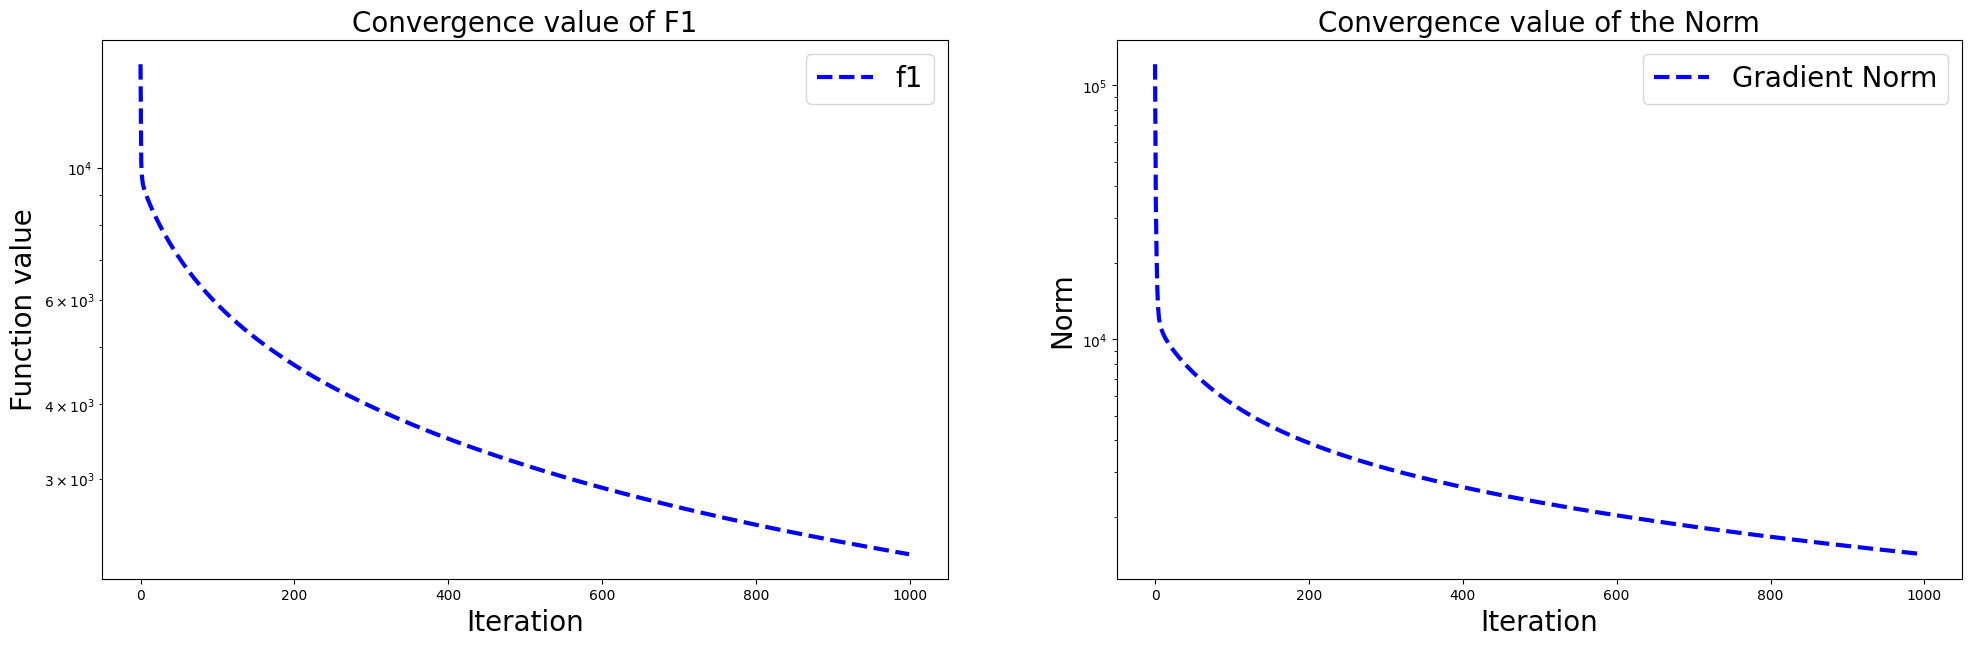

In [50]:
# Function to minimize
def fun (w, A, b, lambda_v):
    return np.linalg.norm(A @ w - b)**2 + lambda_v * np.linalg.norm(w)**2

# Gradient of the function to minimize
def grad_fun (w, A, b, lambda_v):
    return A.T @ (A @ w - b) + lambda_v * w

# Gradient descent
w = np.zeros(A.shape[1])

# L - Lipschitz constant
B = A.T @ A + lambda_v * np.identity(A.shape[1])
L = np.sqrt(np.linalg.eigvals(B.T @ B).max())

# Step size
gamma = 1/L

# Number of iterations
n_iter = 1000
tol = 1

norm_grad_list = []
fun_list = []

i=0
grad = grad_fun(w, A, b, lambda_v)

while i<n_iter and np.linalg.norm(grad) > tol:
    grad = grad_fun(w, A, b, lambda_v)
    norm_grad_list.append(np.linalg.norm(grad))
    fun_list.append(fun(w, A, b, lambda_v))

    w = w - gamma * grad
    i+=1

# Metrics
print("Number of iterations: ", i)
print("Norm of the gradient: ", np.linalg.norm(grad))

#Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,7))

#Plot for fun list
ax1.plot(fun_list, label='f1', color='blue', linewidth=3, linestyle='--')
ax1.set_title('Convergence value of F1', fontsize=20)
ax1.set_xlabel('Iteration', fontsize=20)
ax1.set_ylabel('Function value', fontsize=20)
ax1.legend(fontsize=20)
ax1.set_yscale('log')

#Plot for norm grad list
ax2.plot(norm_grad_list, label='Gradient Norm', color='blue', linewidth=3, linestyle='--')
ax2.set_title('Convergence value of the Norm', fontsize=20)
ax2.set_xlabel('Iteration', fontsize=20)
ax2.set_ylabel('Norm', fontsize=20)
ax2.legend(fontsize=20)
ax2.set_yscale('log')

plt.show()



# Regularization for a sparse model

## 4.1

$$
min_{x \in \mathbb{R}^n}  \frac{1}{2}\|A w-b\|^{2}+\lambda\|w\|
$$

$$
P_i = prox_{g2}(w_i) = argmin_{w \in \mathbb{R}^n} |w| + \frac{1}{2\lambda} \|w - w_i\|^2
$$

Using Fermat's theorem we have that


$$
0 \in \partial \left[|.|(P_i) + \frac{1}{2\lambda}(. - w_i)^{2}(P_i)\right]
$$

$$
0 \in \partial |.|(P_i) + \frac{1}{\lambda}(P_i - w_i)
$$

$$
\frac{1}{\lambda} (w_i - P_i) \in  \partial |.|(P_i)
$$

$$
P_i \in  
\Biggl\{
\begin{aligned}
\lambda + w_i,  P_i < 0\\
w_i + [-\lambda,\lambda],  P_i = 0\\
w_i - \lambda ,  P_i > 0 \\
\end{aligned}
$$


And we have that

$$
\nabla{f(w)}  = A^{T}(Aw-b)

In [51]:
def soft_thresholding (w, gamma):
    return np.sign(w) * np.maximum(np.abs(w) - gamma, 0)

# Proximal gradient descent
def proximal_gradient_descent (w, A, b, gamma, n_iter= 10000, tol=1e-5):
    n,m = A.shape
    w = np.zeros(m)
    alpha = 1.0 / (np.linalg.norm(A.T @ A))

    i=0
    grad = A.T.dot(A.dot(w) - b)

    while i<n_iter and np.linalg.norm(grad) > tol:
        grad = A.T.dot(A.dot(w) - b) 
        w_old = w.copy()
        w = w - alpha * grad
        w = soft_thresholding(w, gamma * alpha)
        i+=1
    
    return w

# Metrics
lambda_v = 100
result = proximal_gradient_descent(w, A, b, lambda_v)
print("Result: ", result)
print("Optimal value: ", np.linalg.norm(A @ result - b)**2 + lambda_v * np.linalg.norm(result)**2)


Result:  [-0.  0.  0. ...  0. -0.  0.]
Optimal value:  1160.2883638925596
